### Importing Libraries

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image
import base64
from io import BytesIO
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


### Loading and Processing Image Data

In [2]:

# Define the path where  images are stored
image_folder = '/content/drive/MyDrive/Burmese Handwritten Digit Recognition/datasets'

# Define the image size for standardize to
image_size = (28, 28)  # Common size for MNIST-like datasets

# Initialize lists to hold the image data and labels
images = []
labels = []

# Loop through each digit folder (0-9)
for label in range(10):
    label_folder = os.path.join(image_folder, str(label))

    # Loop through each image file in the folder
    for filename in os.listdir(label_folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):  # Adjust file types
            image_path = os.path.join(label_folder, filename)

            # Load the image
            img = Image.open(image_path).convert('L')  # Convert to grayscale
            img = img.resize(image_size)  # Resize to uniform size

            # Convert image to numpy array
            img_array = np.array(img)

            # Normalize pixel values (0-255 to 0.0-1.0)
            img_array = img_array / 255.0

            # Append the image data and label to the lists
            images.append(img_array)
            labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)



### Displaying Images

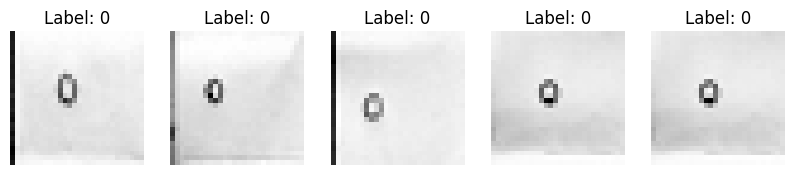

In [3]:
def display_images(images, labels, num_images):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

# Display the first 5 images and their labels
display_images(images, labels,5)

### Train Test Data Splitting

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)




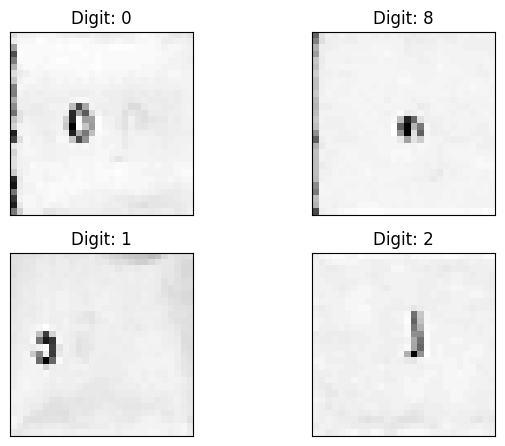

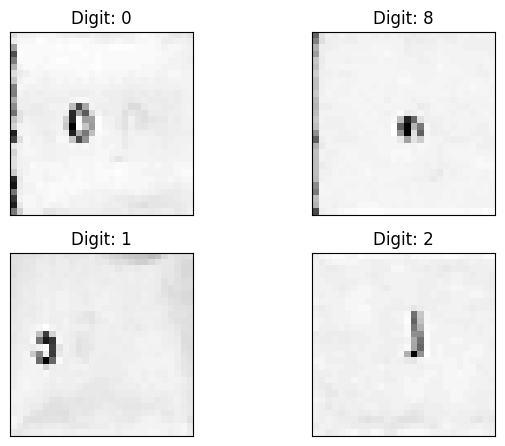

In [5]:
fig = plt.figure()
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [6]:
print("X_train Shape : ", X_train.shape)
print("X_test Shape  : ",  X_test.shape)
print("Y_train Shape : ",y_train.shape)
print("X_train Shape : ",y_train.shape)

X_train Shape :  (1776, 28, 28)
X_test Shape  :  (444, 28, 28)
Y_train Shape :  (1776,)
X_train Shape :  (1776,)


Text(0.5, 1.0, 'Pixel Value Distribution')

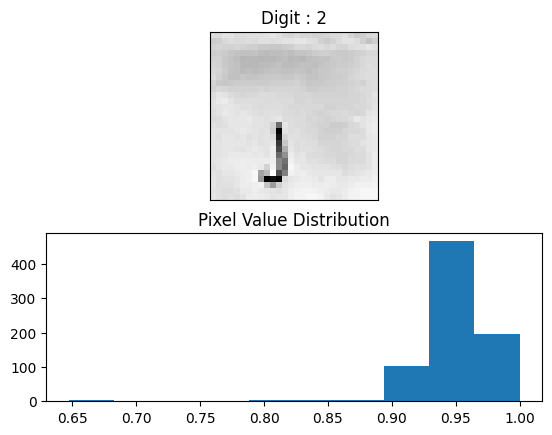

In [7]:

plt.subplot(2,1,1)
plt.imshow(X_train[5],cmap='gray',interpolation='none')
plt.xticks([])
plt.yticks([])
plt.title(f'Digit : {y_train[5]}')
plt.subplot(2,1,2)
plt.hist(X_train[5].reshape(784)) # 28 x 28
plt.title("Pixel Value Distribution")

In [8]:
# building the input vector from the 28x28 pixels
X_train = X_train.reshape(1776, 28,28,1)
X_test = X_test.reshape(444, 28,28,1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

Train matrix shape (1776, 28, 28, 1)
Test matrix shape (444, 28, 28, 1)


### One hot Encoding for labels Data

In [9]:
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([177, 168, 177, 182, 186, 185, 184, 174, 169, 174]))


In [10]:
n_classes = 10
print("Y train shape before encoding : ", y_train.shape)
y_train = to_categorical(y_train,n_classes)
y_test  = to_categorical(y_test,n_classes)
print("Y train shape after encoding : ", y_train.shape)

Y train shape before encoding :  (1776,)
Y train shape after encoding :  (1776, 10)


In [11]:
print(y_train[5])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
model = Sequential()
model.add(Conv2D(64,kernel_size= 3,activation = 'relu', input_shape=(28,28,1)))
model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=None, padding='valid', data_format=None))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,activation='softmax'))

In [13]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 8, 32)          0         
 D)                                                              
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               2

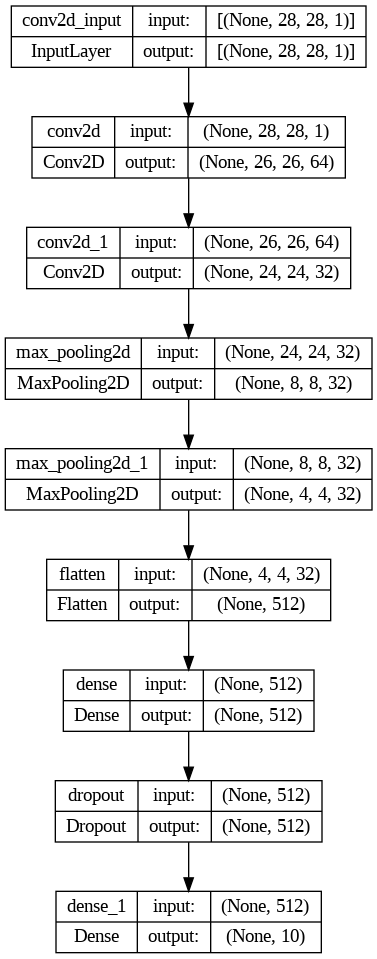

In [17]:
plot_model(model, to_file='/content/drive/MyDrive/Burmese Handwritten Digit Recognition/model.png', show_shapes=True, expand_nested=True)

In [18]:
callback = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('/content/drive/MyDrive/Burmese Handwritten Digit Recognition/best_model.h5', monitor='val_loss', mode='min', verbose=1)
reduce_lr_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='max')

In [20]:
history = model.fit(X_train,y_train,batch_size=10,epochs=20,verbose=1, validation_data =(X_test, y_test), callbacks= [callback, mc, reduce_lr_acc])

Epoch 1/20
176/178 [============================>.] - ETA: 0s - loss: 1.9762 - accuracy: 0.3244
Epoch 1: saving model to /content/drive/MyDrive/Burmese Handwritten Digit Recognition/best_model.h5
178/178 [==============================] - 7s 38ms/step - loss: 1.9738 - accuracy: 0.3277 - val_loss: 1.8480 - val_accuracy: 0.3581 - lr: 0.0010
Epoch 2/20
  3/178 [..............................] - ETA: 4s - loss: 1.7156 - accuracy: 0.3667

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


177/178 [============================>.] - ETA: 0s - loss: 1.6280 - accuracy: 0.4520
Epoch 2: saving model to /content/drive/MyDrive/Burmese Handwritten Digit Recognition/best_model.h5
178/178 [==============================] - 5s 28ms/step - loss: 1.6261 - accuracy: 0.4527 - val_loss: 1.5042 - val_accuracy: 0.4595 - lr: 0.0010
Epoch 3/20
177/178 [============================>.] - ETA: 0s - loss: 1.2728 - accuracy: 0.5989
Epoch 3: saving model to /content/drive/MyDrive/Burmese Handwritten Digit Recognition/best_model.h5
178/178 [==============================] - 7s 40ms/step - loss: 1.2726 - accuracy: 0.5985 - val_loss: 1.1582 - val_accuracy: 0.6441 - lr: 0.0010
Epoch 4/20
177/178 [============================>.] - ETA: 0s - loss: 0.9845 - accuracy: 0.7017
Epoch 4: saving model to /content/drive/MyDrive/Burmese Handwritten Digit Recognition/best_model.h5
178/178 [==============================] - 5s 28ms/step - loss: 0.9826 - accuracy: 0.7027 - val_loss: 0.9136 - val_accuracy: 0.7207 -

In [22]:
model.save('/content/drive/MyDrive/Burmese Handwritten Digit Recognition/Digit_model.h5')

### Evaulting the Model's Performance

In [29]:
loss_and_metrics = model.evaluate(X_test, y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

14/14 - 0s - loss: 0.3480 - accuracy: 0.9009 - 261ms/epoch - 19ms/step
Test Loss 0.34797942638397217
Test Accuracy 0.9009009003639221


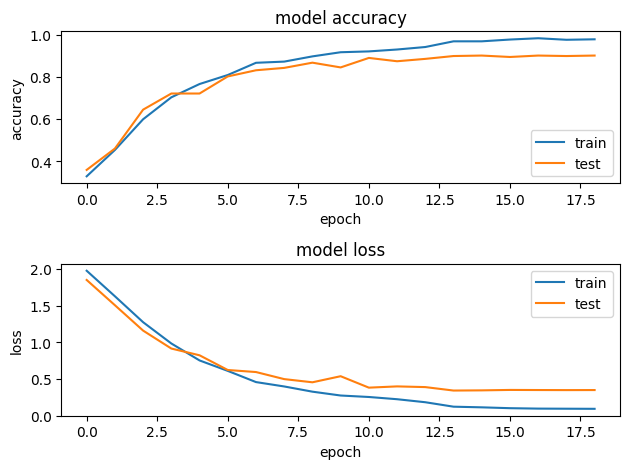

In [28]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()


In [30]:
Digit_model = load_model('/content/drive/MyDrive/Burmese Handwritten Digit Recognition/Digit_model.h5')